# Grupo conformado por:
- Dario Herrrera
- Jacqueline Reina
- Cristina Pavón
- Karen Mangui
- Edgar Silva 
- Magdalena Jingo
- Adriana Porras
- Víctor Pilataxi 
- Mónica Moreta
- Miguel Espinoza

# Importamos paquetes y definimos helpers

Se ha incluído el código base para cargar los datos y transformarlos en formato diario. Además de algunas funciones que nos ayuden a verificar outliers, como también para evaluar el modelo. 

PISTA: Si queremos predecir la cantidad de usuarios, las columnas casual y registered no nos serán útiles ya que contienen información a posteriori. 

In [215]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error , r2_score 
import seaborn as sns



def get_median_filtered(signal, threshold=3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(signal, threshold = 3, return_mask = True):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show()
    if return_mask: 
      return outlier_idx


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def evaluate(true, pred):
    print('Mean squared error: %.2f'% mean_squared_error(true, pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'% r2_score(true, pred))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(true, pred))

## Cargamos los Datos y exploración inicial 

In [216]:
#gdrive location:
url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/forecasting_exercise.csv'
df = pd.read_csv(url,parse_dates = ["dteday"]) 

In [217]:
df.tail(
    
)

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,19,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,20,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,22,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,23,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2727,0.65,0.1343,12,37,49


In [218]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB
None


In [219]:
# Revisamos la cantidad de valores vacíos en las variables
df.isnull().sum()

instant         0
dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

In [220]:
df[df["weathersit"].isnull()]

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
328,329,2011-01-15,4,NaN,0.16,0.2273,0.59,0.0000,0,5,5
956,957,2011-02-12,11,NaN,0.30,0.2727,0.28,0.3284,30,84,114
1052,1053,2011-02-16,14,NaN,0.46,0.4545,0.28,0.4179,17,65,82
1101,1102,2011-02-18,15,NaN,0.66,0.6212,0.36,0.3284,55,117,172
1302,1303,2011-02-27,11,NaN,0.36,0.3485,0.62,0.1343,33,92,125
...,...,...,...,...,...,...,...,...,...,...,...
16447,16448,2012-11-23,1,NaN,0.28,0.3030,0.81,0.0896,2,11,13
16473,16474,2012-11-24,3,NaN,0.28,0.2576,0.41,0.3582,6,5,11
16859,16860,2012-12-10,6,NaN,0.38,0.3939,0.94,0.1642,2,121,123
16966,16967,2012-12-14,17,NaN,0.34,0.3333,0.57,0.1642,40,582,622


In [221]:
# Revisamos la cantidad de valores únicos en la variable descripción del clima
df['weathersit'].unique()

array(['Clear, Few clouds, Partly cloudy, Partly cloudy',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       nan, 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'],
      dtype=object)

# Predicción de Series Temporales utilizando FbProphet

La predicción de series temporales es de los casos más habituales y aplicables dentro del Machine Learning. Por ejemplo, models de 'forecasting' se pueden encontrar en para la predicción de precios, demanda, temperatura,  tiempo de respuesta, ventas, ritmo cardiaco, producción, etc. 

El gran reto se encuentra en que, a diferencia de algunos otros casos de Machine Learning, la predicción a futuro depende en gran medida, de los datos históricos de la serie. Es decir, por ejemplo si queremos predecir la temperatura media por hora, el dato más relevante que podemos utilizar es la misma serie de temperaturas por hora. A este tipo de modelos se los llama **Auto-regresivos.** 

En la práctica, los modelos auto-regresivos pueden desarrollarse sin ninguna otra variable auxiliar (covariantes), sin embargo, es común añadir regresores externos para complementar el poder predictivo del modelo. 

## Caso de uso: Predicción de la demanda de Bicicletas en una plataforma de BikeSharing en Washington DC. 

Somos Data Scientist en una empresa de Bike Sharing. Básicamente es una aplicación en donde los usuarios pueden registrarse, utilizar bicicletas de nuestra empresa que están localizadas a lo largo de la ciudad, y luego, cuándo llegan a destino, las dejan para que otros usuarios puedan usarlas también. La empresa está en proceso de expansión, por lo que han decidido comprar nuevas bicicletas para colocarlas a lo largo de toda la ciudad. Sin embargo, se ha decidido que se comprarán las bicicletas en función de la cantidad de demanada diaria en el futuro. Por lo que se nos ha pedido que realicemos un modelo de predicción de la demanda. La compra tendrá que hacerse urgentemente, por lo que el reto será predecir la demanda de las siguientes dos semanas. 

- Para ello tenemos datos históricos de demanda y la siguiente información:
    - instant: identificador de la fila.
    - dteday: fecha.
    - hr: hora.
    - weathersit: descripción de la situación climática
    - temp: temperatura en celcius (normalizado con división por 41 (max))
    - atemp: sensación térmica (normalizado, dividido por 50 (max))
    - hum: humedad normalizada. Valores divividos por 100 (max)
    - windspeed: velocidad del viento normalizada
    - casual: conteo de usuarios casuales (no registrados)
    - registered: conteo de usuarios registrados en la app
    - cnt: conteo total usuarios (registrados y casuales). Esta sería la variable objetivo.


Reto: Predecir la demanda de uso para las siguientes dos semanas (14 días)!  



In [222]:
w = pd.get_dummies(df["weathersit"])
df = pd.concat([df, w], axis=1)

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column                                                                                   Non-Null Count  Dtype         
---  ------                                                                                   --------------  -----         
 0   instant                                                                                  17379 non-null  int64         
 1   dteday                                                                                   17379 non-null  datetime64[ns]
 2   hr                                                                                       17379 non-null  int64         
 3   weathersit                                                                               17279 non-null  object        
 4   temp                                                                                     17280 non-null  float64       
 5   atemp      

In [224]:
df.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,"Clear, Few clouds, Partly cloudy, Partly cloudy","Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog","Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist"
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16,1,0,0,0
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40,1,0,0,0
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32,1,0,0,0
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13,1,0,0,0
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1,1,0,0,0


In [225]:
# localizamos los valores null
null_columns= df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
dtype: int64

C:\Users\adria\AppData\Local\Temp\ipykernel_19168\3117438771.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

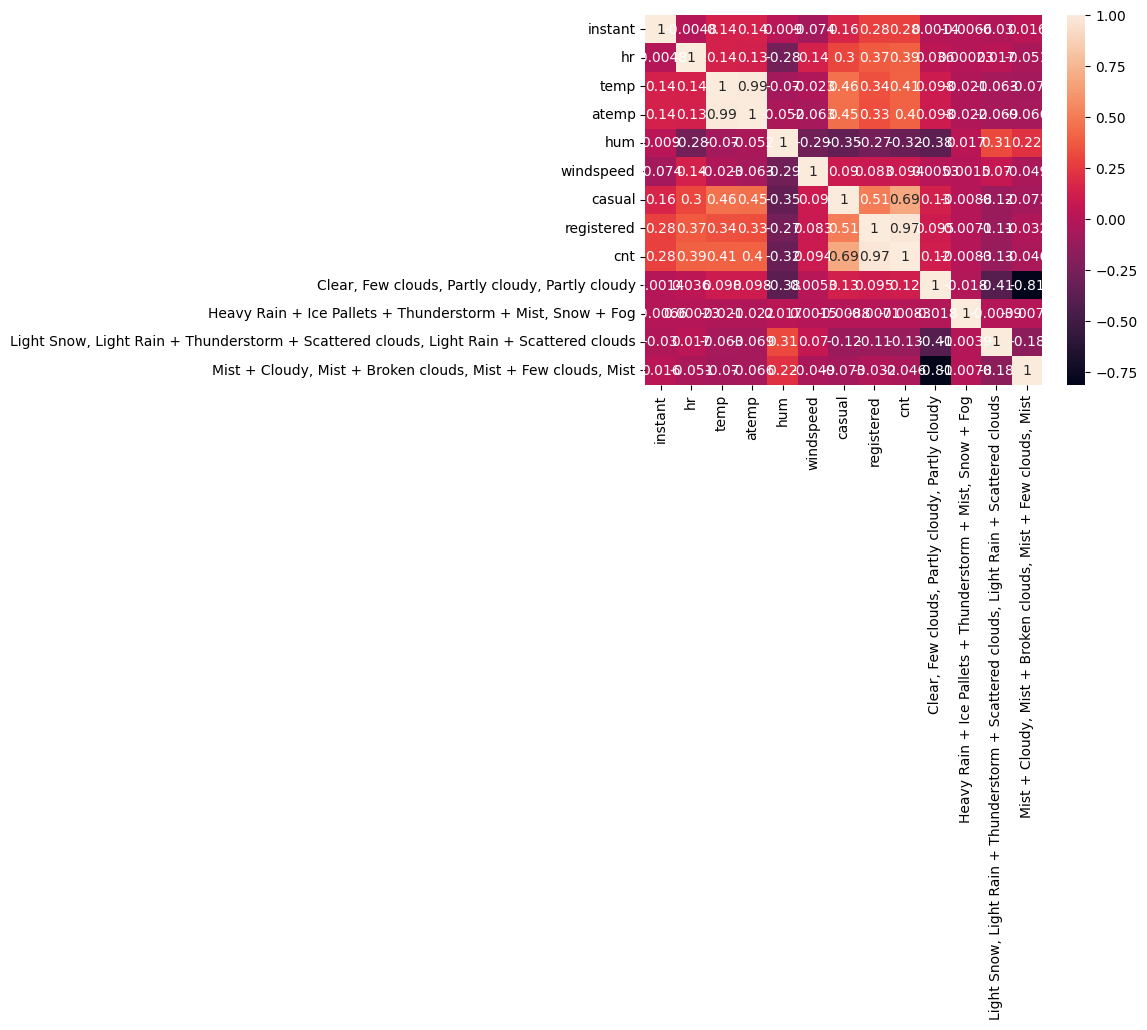

In [226]:
corr = df.corr() 
sns.heatmap(corr, annot = True)

In [227]:
df.dropna(inplace=True)

In [228]:
# localizamos los valores null
df.isnull().sum()

instant                                                                                    0
dteday                                                                                     0
hr                                                                                         0
weathersit                                                                                 0
temp                                                                                       0
atemp                                                                                      0
hum                                                                                        0
windspeed                                                                                  0
casual                                                                                     0
registered                                                                                 0
cnt                                                                   

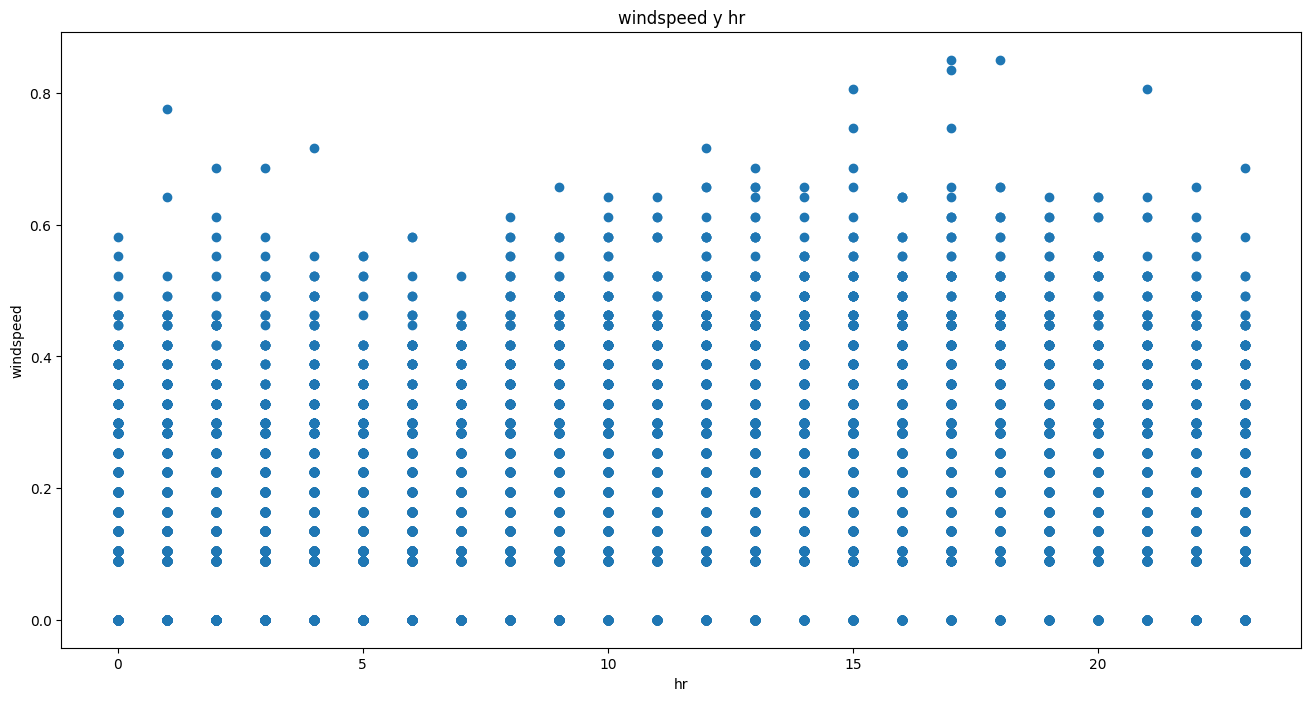

In [229]:
x = 'hr'
y = 'windspeed'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

In [230]:
df['dteday']=pd.to_datetime(df['dteday'])
df['year']=df['dteday'].dt.year
df['quarter']=df['dteday'].dt.quarter
df['month']=df['dteday'].dt.month
df['day_of_week']=df['dteday'].dt.day_name()
df['hour']=df['dteday'].dt.hour

df['weathersit']=df['weathersit'].map({1:'Clear,Few clouds,Partly cloudy,Partly cloudy',
                                       2:'Mist+Cloudy,Mist+Brokenclouds,Mist+Fewclouds,Mist',
                                       3:'LightSnow,LightRain+Thunderstorm+Scattered clouds,Light Rain+Scatteredclouds',
                                       4:'Heavy Rain+Ice Pallets+Thunderstorm+Mist,Snow+Fog'})

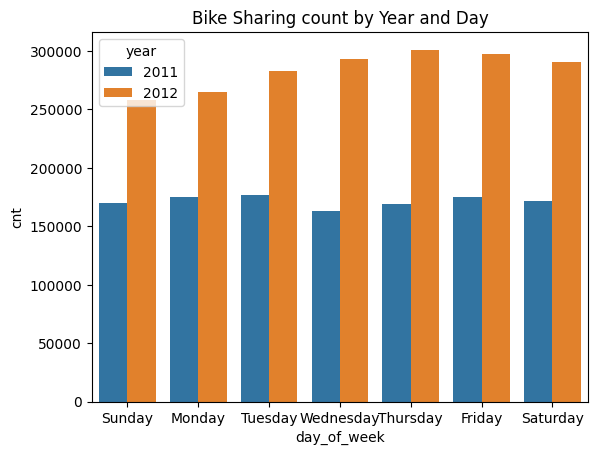

In [231]:
year_day_count=df.groupby(['year','day_of_week'])['cnt'].sum().reset_index()
order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
sns.barplot(data=year_day_count,x='day_of_week',y='cnt',hue='year',order=order)
plt.title('Bike Sharing count by Year and Day')
plt.show()

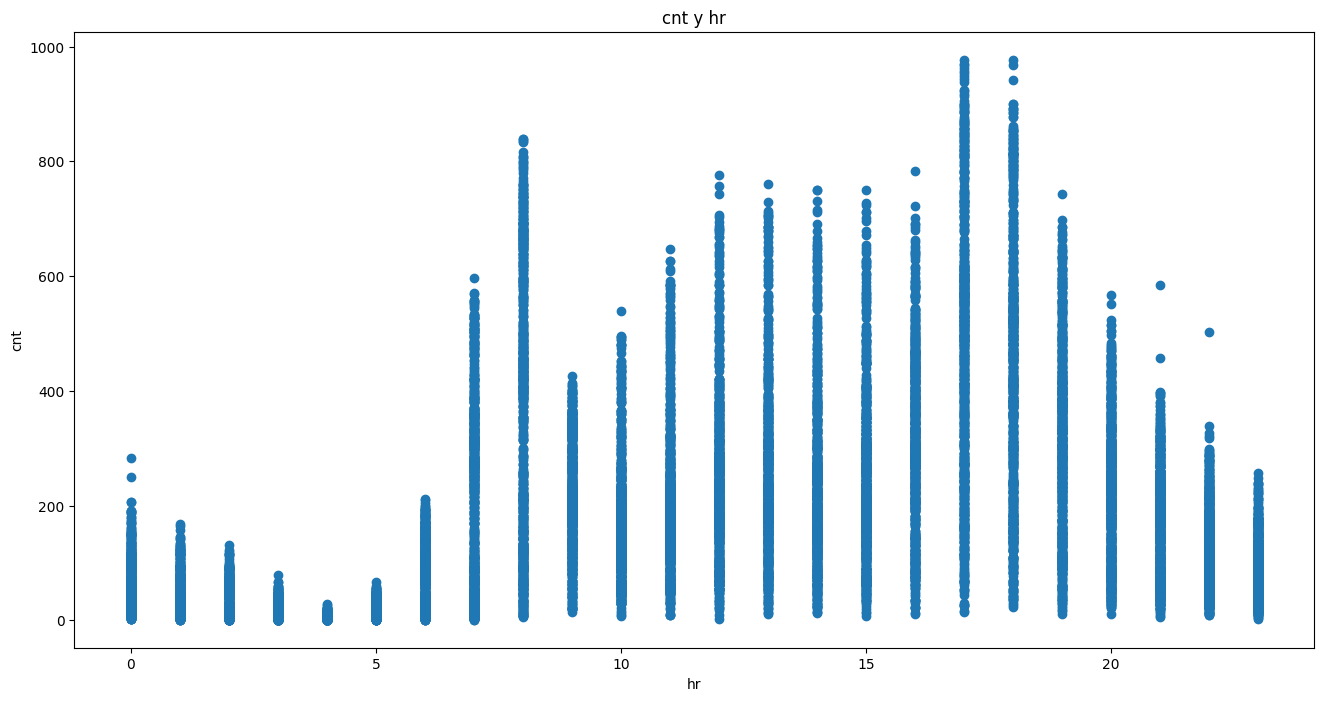

In [232]:
x = 'hr'
y = 'cnt'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

C:\Users\adria\AppData\Local\Temp\ipykernel_19168\78905792.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,cmap="viridis", vmin = -1, vmax = 1)


<AxesSubplot: >

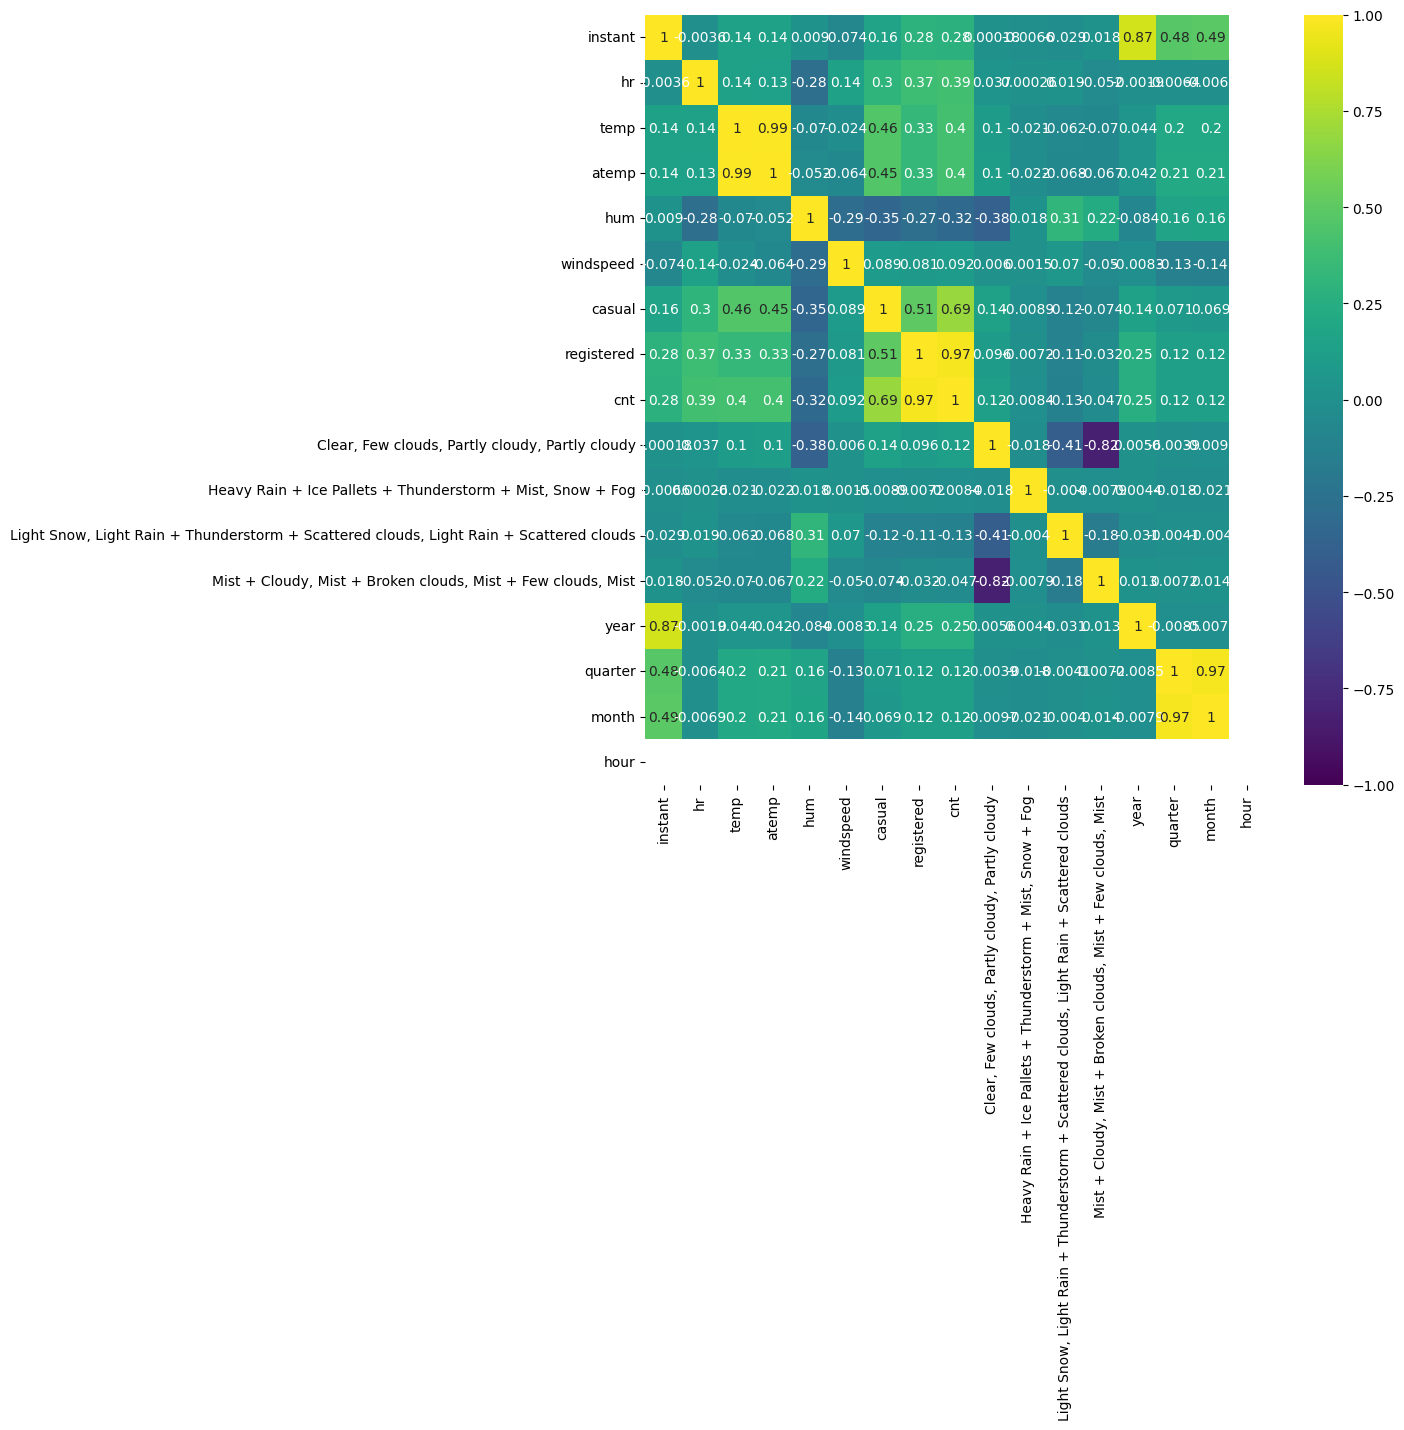

In [233]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap="viridis", vmin = -1, vmax = 1)

# Formato Datos 

Los datos están por hora, lo que dificulta en gran medida el análisis ya que se agrega muchísimo ruido de horas poco útiles. Para este caso de uso, trabajaremos con predicción de la demanda diaria. 

In [234]:
df_byday = df.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day 

In [235]:
df_byday.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1217
3,2011-01-04,1562
4,2011-01-05,1600


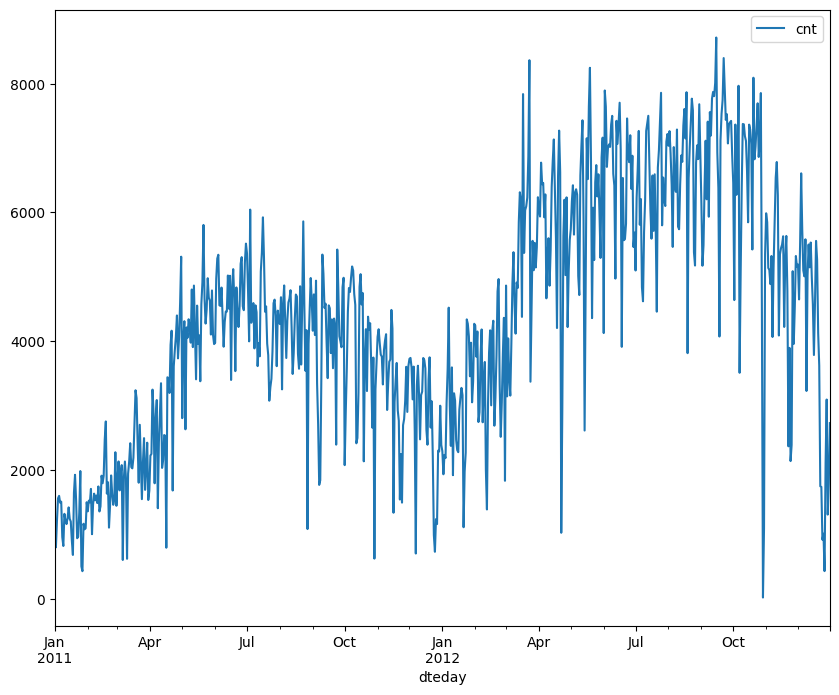

In [236]:
df_byday.plot(x='dteday',y='cnt', figsize=(10,8))
plt.show()

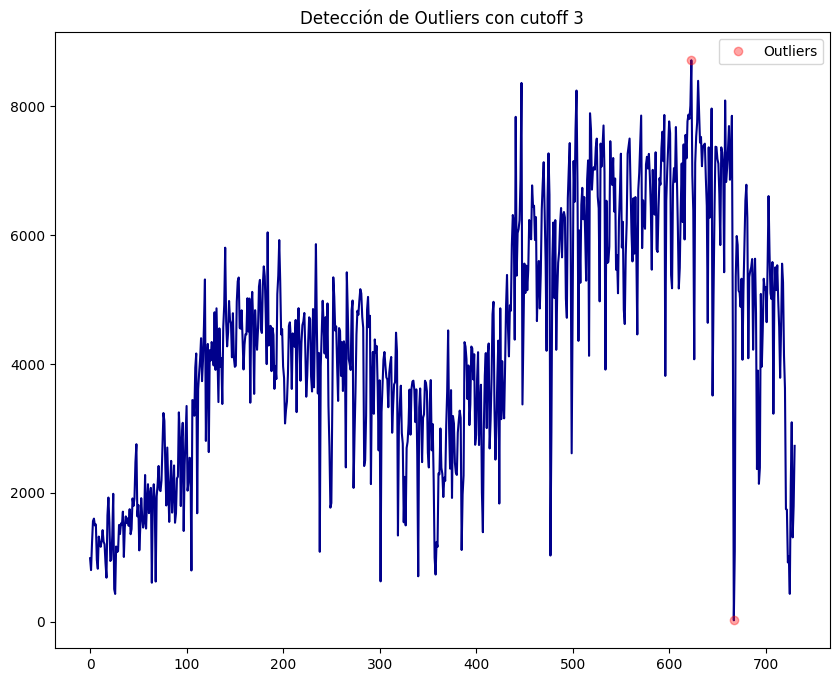

In [237]:
# Outliers
indices = plot_outliers_signal(df_byday.cnt.values, threshold = 3)
plt.show()

In [238]:
df_byday.iloc[indices]

,dteday,cnt
623,2012-09-15,8714
667,2012-10-29,22


Agregamos todas las variables que nos eran útiles. Sin embargo, no todas las podemos tratar de la misma forma

# Feature Engineering ( Creamos variables a raíz de nuestros datos)

In [239]:
# Código de feature engineering.

# Modelo de Machine Learning

In [240]:
# Resolución Modelo

# Evaluación Modelo